In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import sys

sys.path.append("../../")
from lib.general import get_stage_list

### Input

In [2]:
# Specify I/O paths
path_input_demographics: Path = Path(
    "../../../data/original/adni/ADNIMERGE_14Jul2023.csv"
).resolve()
path_input_bmi: Path = Path("../../../data/processed/adni/bmi.csv").resolve()
path_input_strem2: Path = Path("../../../data/processed/adni/strem2.csv").resolve()
path_input_ab4240: Path = Path("../../../data/processed/adni/ab4240.csv").resolve()
path_output: Path = Path(
    "../../../data/processed/adni/demographics_biomarkers.csv"
).resolve()

In [3]:
# Determine columns to be used in the analysis
usecols_: list[str] = [
    "RID",
    "VISCODE",
    "EXAMDATE",
    "DX_bl",
    "AGE",
    "PTGENDER",
    "APOE4",
    "ABETA_bl",
    "AV45_bl",
    "PTAU_bl",
    "TAU_bl",
]
dtype_: dict[str, type] = {"ABETA_bl": str, "PTAU_bl": str, "TAU_bl": str}

In [4]:
# Read files
df_demographics: pd.DataFrame = (
    pd.read_csv(
        path_input_demographics,
        usecols=usecols_,
        parse_dates=["EXAMDATE"],
        dtype=dtype_,
    )
    .dropna()
    .drop_duplicates()
    .convert_dtypes()
)
df_bmi: pd.DataFrame = pd.read_csv(path_input_bmi).convert_dtypes()
df_strem2: pd.DataFrame = pd.read_csv(
    path_input_strem2, parse_dates=["EXAMDATE"]
).convert_dtypes()
df_ab4240: pd.DataFrame = pd.read_csv(path_input_ab4240).convert_dtypes()

### Processing

In [5]:
# Join dataframes
df: pd.DataFrame = (
    df_demographics.join(df_bmi.set_index("RID"), on="RID", how="inner")
    .join(
        df_strem2.set_index("RID"),
        on="RID",
        how="inner",
        lsuffix="_pet",
        rsuffix="_strem2",
    )
    .dropna()
    .drop_duplicates()
    .convert_dtypes()
    .reset_index(drop=True)
)

In [6]:
# Include only participants with baseline visit data
df: pd.Series | pd.DataFrame = df.loc[df["VISCODE"].isin(["bl"])]

In [7]:
# Exclude participants with AD diagnosis
df: pd.Series | pd.DataFrame = df.loc[~df["DX_bl"].isin(["AD"])]

In [8]:
# Keep only rows where amyloid PET and sTREM2 examdates are fewer than 180 days apart
df: pd.Series | pd.DataFrame = df.loc[
    abs((df["EXAMDATE_strem2"] - df["EXAMDATE_pet"]).dt.days) < 180
]

In [9]:
# Define boolean columns
df["cog"] = df["DX_bl"].isin(["EMCI", "LMCI"]).astype(bool)
df["apoe4"] = (df["APOE4"] > 0).astype(bool)
df["sex"] = (df["PTGENDER"] == "Male").astype(bool)

In [10]:
# Transform biomarker values to float, censoring values with '<' or '>' at the boundaries
df["ab42"] = (
    df["ABETA_bl"]
    .astype(str)
    .str.replace(pat="[><]", repl="", regex=True)
    .astype(float)
)
df["ptau"] = (
    df["PTAU_bl"].astype(str).str.replace(pat="[><]", repl="", regex=True).astype(float)
)
df["ttau"] = (
    df["TAU_bl"].astype(str).str.replace(pat="[><]", repl="", regex=True).astype(float)
)

In [11]:
# Display info
df: pd.DataFrame = (
    df.dropna().sort_values(by="RID", ascending=True).reset_index(drop=True)
)
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   RID              570 non-null    Int64         
 1   VISCODE          570 non-null    string        
 2   EXAMDATE_pet     570 non-null    datetime64[ns]
 3   DX_bl            570 non-null    string        
 4   AGE              570 non-null    Float64       
 5   PTGENDER         570 non-null    string        
 6   APOE4            570 non-null    Int64         
 7   ABETA_bl         570 non-null    string        
 8   TAU_bl           570 non-null    string        
 9   PTAU_bl          570 non-null    string        
 10  AV45_bl          570 non-null    Float64       
 11  bmi              570 non-null    Float64       
 12  EXAMDATE_strem2  570 non-null    datetime64[ns]
 13  strem2           570 non-null    Float64       
 14  strem2_log10     570 non-null    Float64  

### Histograms

Age

<Axes: >

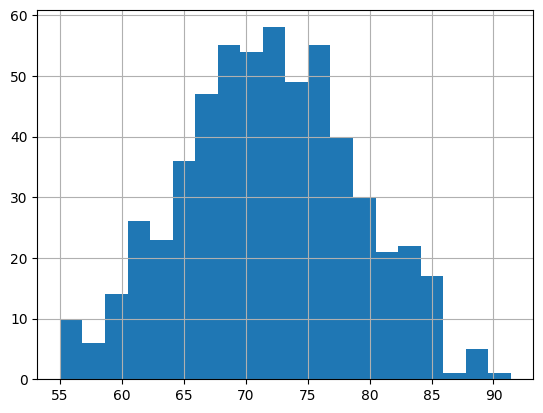

In [12]:
# Age distribution
df["AGE"].hist(bins=20)

Beta Amyloid 42

<Axes: >

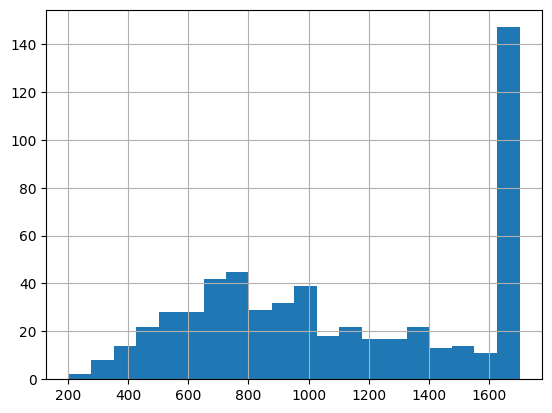

In [13]:
# Ab42 distribution
# Note: Value '>1700' is censored at 1700

df["ab42"].hist(bins=20)

Amyloid PET

<Axes: >

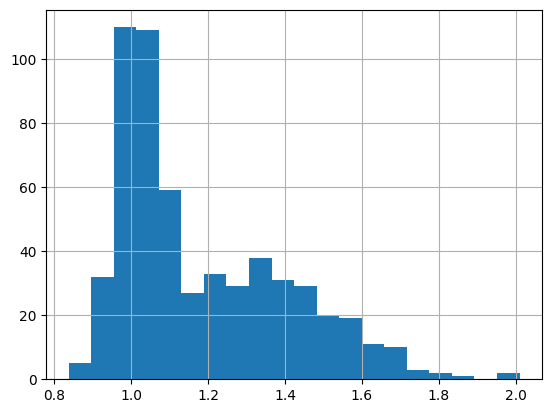

In [14]:
# AV45 distribution
df["AV45_bl"].hist(bins=20)

pTau

Text(26.599999999999998, 120, '26.60')

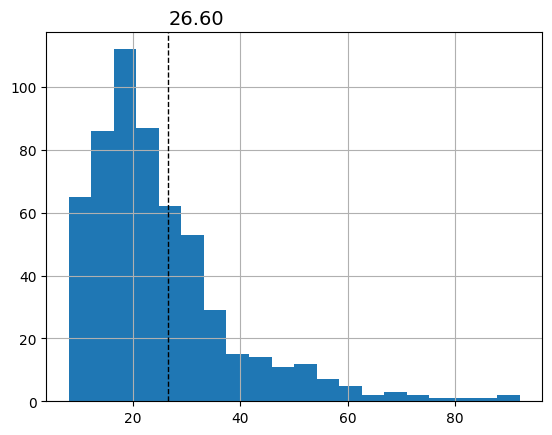

In [15]:
# PTAU distribution with cutoff at 2/3 quantile
df["ptau"].hist(bins=20)
plt.axvline(df["ptau"].quantile(2 / 3), color="k", linestyle="dashed", linewidth=1)
plt.text(
    df["ptau"].quantile(2 / 3),
    120,
    f"{df['ptau'].quantile(2 / 3):.2f}",
    rotation=0,
    fontsize=14,
)

Total Tau

Text(285.4666666666666, 100, '285.47')

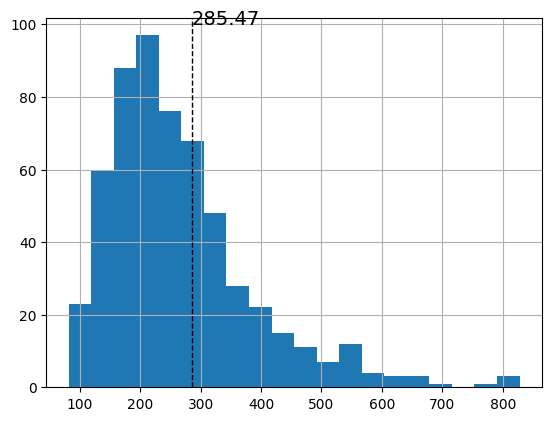

In [16]:
# TAU distribution with cutoff at 2/3 quantile
df["ttau"].hist(bins=20)
plt.axvline(df["ttau"].quantile(2 / 3), color="k", linestyle="dashed", linewidth=1)
plt.text(
    df["ttau"].quantile(2 / 3),
    100,
    f"{df['ttau'].quantile(2 / 3):.2f}",
    rotation=0,
    fontsize=14,
)

Text(22, 100, '0.023')

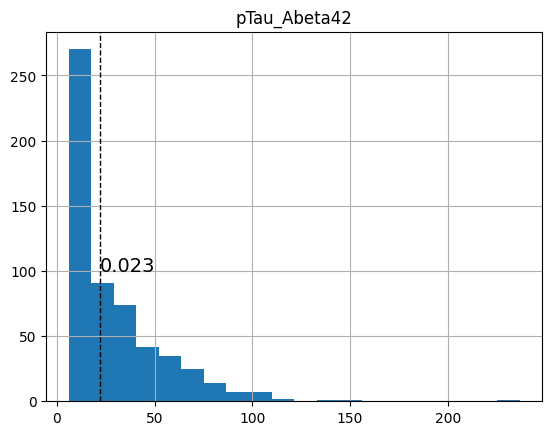

In [17]:
df["ptau_ab42"] = (1000 * df["ptau"] / df["ab42"]).astype(float)
df["ptau_ab42"].hist(bins=20)
plt.title("pTau_Abeta42")
plt.axvline(22, color="k", linestyle="dashed", linewidth=1)
plt.text(22, 100, f"0.023", rotation=0, fontsize=14)

In [18]:
# Get stage list
stage_list: list[str] = get_stage_list(2)

In [19]:
# Define biomarker positivity/negativity
# df["ab_positive"] = (df["ab42"] < 976.6).astype(bool)
df["ab_positive"] = (df["ptau_ab42"] > 23).astype(bool)
df["pet_positive"] = (df["AV45_bl"] > 1.11).astype(bool)
df["ptau_positive"] = (df["ptau"] > (df["ptau"].quantile(2 / 3))).astype(bool)
df["ttau_positive"] = (df["ttau"] > (df["ttau"].quantile(2 / 3))).astype(bool)

In [20]:
# # Stage definition on three biomarkers
# df.loc[~df['ab_positive'] & ~df['pet_positive'] & ~df['ptau_positive'], 'stage'] = stage_list[0]
# df.loc[ df['ab_positive'] & ~df['pet_positive'] & ~df['ptau_positive'], 'stage'] = stage_list[1]
# df.loc[ df['ab_positive'] &  df['pet_positive'] & ~df['ptau_positive'], 'stage'] = stage_list[3]
# df.loc[ df['ab_positive'] &  df['pet_positive'] &  df['ptau_positive'], 'stage'] = stage_list[5]
# df.loc[~df['ab_positive'] & ~df['pet_positive'] &  df['ptau_positive'], 'stage'] = stage_list[6]

# df.loc[~df['ab_positive'] &  df['pet_positive'] & ~df['ptau_positive'], 'stage'] = stage_list[2]
# df.loc[~df['ab_positive'] &  df['pet_positive'] &  df['ptau_positive'], 'stage'] = stage_list[4]

# df.loc[ df['ab_positive'] & ~df['pet_positive'] &  df['ptau_positive'], 'stage'] = 'excluded'

In [21]:
# Stage definition on two biomarkers
df.loc[~df["ab_positive"] & ~df["pet_positive"], "stage"] = stage_list[0]
df.loc[df["ab_positive"] & ~df["pet_positive"], "stage"] = stage_list[1]
df.loc[~df["ab_positive"] & df["pet_positive"], "stage"] = stage_list[2]
df.loc[df["ab_positive"] & df["pet_positive"], "stage"] = stage_list[3]

In [22]:
# Convert stage to categorical
df["stage"] = pd.Categorical(df["stage"], categories=stage_list, ordered=True)
df: pd.DataFrame = (
    df.dropna().sort_values(by="RID", ascending=True).reset_index(drop=True)
)

### Export

In [23]:
# Columns to export and their names
cols_exp: list[str] = [
    "RID",
    "AGE",
    "sex",
    "bmi",
    "cog",
    "apoe4",
    "ab42",
    "AV45_bl",
    "ptau",
    "ttau",
    "strem2",
    "strem2_log10",
    "stage",
    "ptau_ab42",
]
names_exp: list[str] = [
    "RID",
    "age",
    "sex",
    "bmi",
    "cog",
    "apoe4",
    "ab42",
    "av45",
    "ptau",
    "ttau",
    "strem2",
    "strem2_log10",
    "stage",
    "ptau_ab42",
]

In [24]:
# Subset and rename columns
df_exp: pd.DataFrame = df[cols_exp].rename(columns=dict(zip(cols_exp, names_exp)))

In [25]:
df_exp.to_csv(path_output, index=False)